# ByT5 모델 학습 및 추론 Notebook
----------
# 실험 코드 구성
#### 1. 라이브러리 Import
#### 2. 사용 함수 정의
#### 3. 데이터 확인 및 전처리
#### 4. 데이터 전처리 
#### 5. 학습
#### 6. 추론 

----------


# 1. 라이브러리 Import

In [19]:
# import comet_ml
# from transformers.integrations import CometCallback
import random
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import numpy as np
import datetime
from langchain.text_splitter import RecursiveCharacterTextSplitter

### +) GPU 설정 및 시드 고정

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

### +) 시각화 툴(Comet ML) 실험 초기화

실험 기록에 Comet ML을 이용  
(WandaDB를 사용하시는 분들은 대체 하시면 될 듯 합니다.)

In [22]:
# today = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# experiment = comet_ml.start(
#     api_key="-",  # 실제 API key 입력
#     project_name="unreadable-korean",
#     workspace="kong"
# )
# experiment.set_name(f"run_{today}")

-----
# 2. 사용 함수 정의

## 2-1. 입력 텍스트 길이 확인 함수 정의
데이터셋의 입력 텍스트에 대한 분석 진행
- 입력 텍스트 토큰 길이를 확인 
- 분포와 최대 길이를 시각화해서 분석

In [23]:
def check_max_length(tokenizer, df):
    all_texts = df["input"]
    lengths = []
    for text in all_texts:
        token_ids = tokenizer.encode(text, add_special_tokens=True)
        lengths.append(len(token_ids))
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, alpha=0.75, edgecolor='black')
    plt.title('토큰 길이 분포 확인')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

## 2-2. 커스텀 char F1 계산 함수 정의

예측 문자열과 정답 문자열 간의 문자 단위 F1 score를 계산하는 함수  
- 해당 평가 산식을 지표로 이용해서 훈련을 진행
- 대회 평가에 적합한 성능 기대

In [24]:
def compute_char_f1_for_lists(pred_texts, ref_texts):
    f1_scores = []
    for pred_text, ref_text in zip(pred_texts, ref_texts):
        if not isinstance(pred_text, str):
            pred_text = "" if pd.isna(pred_text) else str(pred_text)
        if not isinstance(ref_text, str):
            ref_text = "" if pd.isna(ref_text) else str(ref_text)
        pred_text = pred_text.strip()
        ref_text = ref_text.strip()
        num_same = sum(
            1 for i in range(min(len(pred_text), len(ref_text))) if pred_text[i] == ref_text[i]
        )
        if len(pred_text) == 0 or len(ref_text) == 0:
            f1 = 0.0
        else:
            precision = num_same / len(pred_text)
            recall = num_same / len(ref_text)
            if (precision + recall) == 0:
                f1 = 0.0
            else:
                f1 = 2 * precision * recall / (precision + recall)
        f1_scores.append(f1)
    avg_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0.0
    return {"char_f1": avg_f1}

def compute_metrics(pred):
    preds = pred.predictions
    labels = pred.label_ids
    # -100 토큰을 패딩 토큰 ID로 대체 (디코딩 오류 방지)
    labels = [
        [token if token != -100 else tokenizer.pad_token_id for token in label_seq]
        for label_seq in labels
    ]
    preds = np.clip(preds, 0, tokenizer.vocab_size - 1)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = compute_char_f1_for_lists(decoded_preds, decoded_labels)
    return result

## 2-3. 전처리 함수 정의 (Chunk 단위 분할 적용)

Chunk란 데이터를 잘라서 사용하는 것.  
- 문맥의 손실의 위험성이 발생함.  

- 그럼에도 불구하고 Chunk를 사용한 이유는?

1. 데이터 상의 입력 텍스트가 상당히 길다.  
2. 사용한 모델인 ByT5가 데이터 자체를 Byte로 만들어 사용하다 보니, 가뜩이나 긴 입력 데이터가 더 길어짐
3. 하지만 훈련데이터를 짤라서 버릴 수 없다. 주어진 환경에서 최대한 많은 문장을 훈련하고자, 문맥이 잘리는 것을 감안


In [25]:
#훈련시 사용
def preprocess_with_chunking(examples, tokenizer, max_length=1024, chunk_overlap=100):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_length,
        chunk_overlap=chunk_overlap
    )
    new_inputs = []
    new_outputs = []
    for input_text, output_text in zip(examples['input'], examples['output']):
        if not isinstance(input_text, str):
            input_text = str(input_text)
        chunks = splitter.split_text(input_text)
        for chunk in chunks:
            new_inputs.append(chunk)
            new_outputs.append(output_text)
    tokenized_inputs = tokenizer(
        new_inputs,
        max_length=max_length,
        truncation=True,
        padding="longest"
    )
    tokenized_labels = tokenizer(
        new_outputs,
        max_length=max_length,
        truncation=True,
        padding="longest"
    ).input_ids
    tokenized_inputs["labels"] = tokenized_labels
    return tokenized_inputs

## 2-4. 추론 시 데이터 처리 함수 정의 (Chunk 단위 분할 적용)


** 훈련시의 데이터 전처리를 동일하게 적용해서 추론

In [26]:
#추론시 사용
def predict_with_chunking(example, tokenizer, model, 
                           chunk_size=1024, chunk_overlap=100, 
                           gen_max_tokens=1024):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = splitter.split_text(example['input'])
    outputs = []
    for chunk in chunks:
        inputs = tokenizer(
            chunk,
            return_tensors="pt",
            max_length=chunk_size,
            truncation=False,
            padding="longest"
        ).to(model.device)
        result = model.generate(
            **inputs,
            num_beams=4,
            repetition_penalty=2.3,
            max_new_tokens = len(tokenizer.encode(example['input'])) + 100,
            do_sample=False
        )
        out_text = tokenizer.decode(result[0], skip_special_tokens=True)
        outputs.append(out_text)
    final_output = " ".join(outputs)
    return final_output

-------
# 3. 모델 및 토크나이저 로드 

- ByT5에서는 글자 자체를 인코딩해서 사용하기 때문에 토크나이저가 필요 없음
- 여기서 AutoTokenizer Class는 토크나이저가 아닌 인코딩의 역할을 함

In [27]:
model_name = "google/byt5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

------
# 4. 데이터 확인 및 전처리



## 4-1. 데이터 로드


In [28]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
sample_submission_df = pd.read_csv('data/sample_submission.csv')

## 4-2. Byte화 된 데이터 분포 확인
- Model의 입력데이터 형태에 따라 달라짐
- ByT5의 입력데이터는 문장을 Byte화 후 사용
- 해당 문장의 Byte화 된 길이를 확인 후에 Chunk방식의 입력 데이터 전처리 결정

c:\Users\KONG\anaconda3\envs\unreadable_ko\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53664 (\N{HANGUL SYLLABLE TO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KONG\anaconda3\envs\unreadable_ko\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53360 (\N{HANGUL SYLLABLE KEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KONG\anaconda3\envs\unreadable_ko\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KONG\anaconda3\envs\unreadable_ko\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\KONG\anaconda3\envs\unreadable_ko\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48516 (\N{

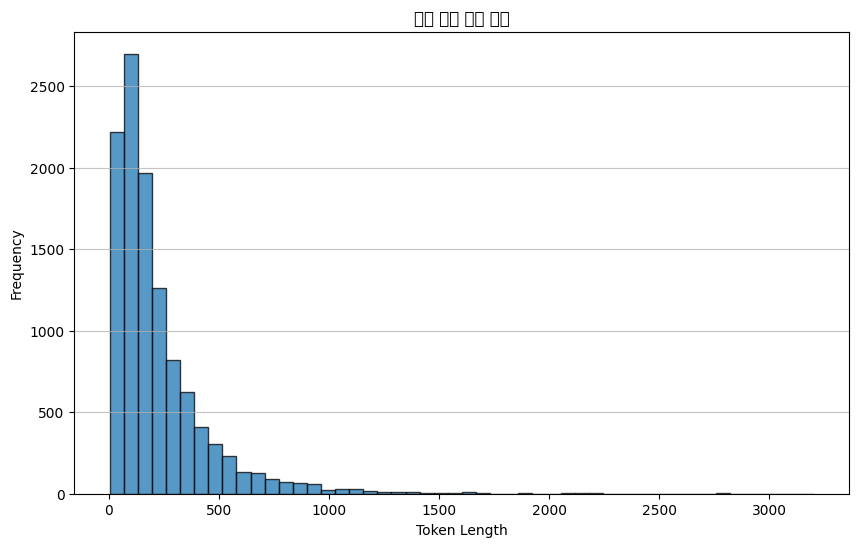

In [29]:
#Train 입력 데이터 길이 분포
check_max_length(tokenizer, train_df)

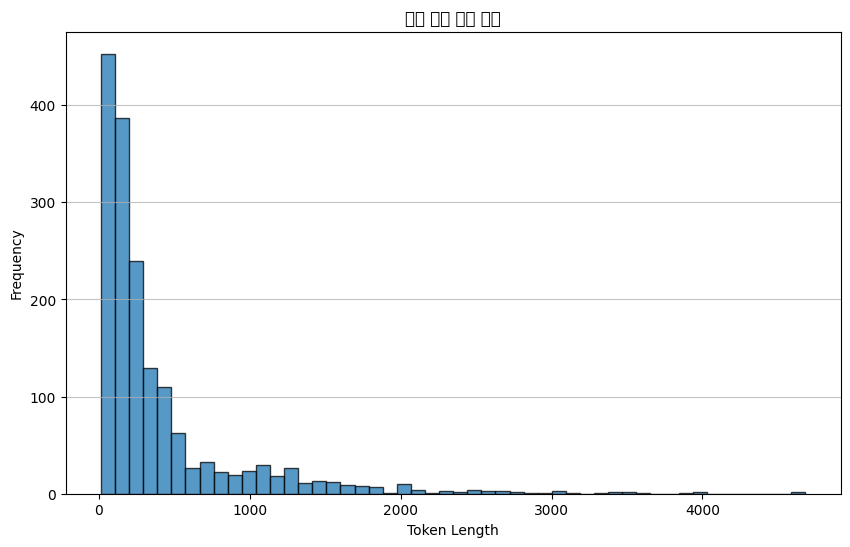

In [30]:
#Test 입력 데이터 길이 분포
check_max_length(tokenizer, test_df)

## 4-3. 데이터 전처리
- train_max_len(1024) : ByT5의 모델 최대 입력 길이 참조 

In [31]:
train_max_len = 1024

In [32]:
# ---------------------- 데이터셋 준비 (청크 기반 전처리 적용) ----------------------
train_data, val_data = train_test_split(train_df, test_size=0.005, random_state=42)
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
# 청크 단위 전처리 함수 적용
train_dataset = train_dataset.map(lambda examples: preprocess_with_chunking(examples, tokenizer ,max_length=train_max_len, chunk_overlap=100), batched=True, remove_columns=train_dataset.column_names)
val_dataset   = val_dataset.map(lambda examples: preprocess_with_chunking(examples, tokenizer, max_length=train_max_len, chunk_overlap=100), batched=True, remove_columns=val_dataset.column_names)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Map: 100%|██████████| 57/57 [00:00<00:00, 2130.95 examples/s]


-------
# 5. 훈련

## 5-1. 인자 설정(초기화)
- ByT5은 Transformer Encoder-Decoder 기반의 seq2seq 모델
- 그러므로 Seq2SeqTrainer 사용이 적합하다고 판단

In [33]:
# Seq2SeqTrainig
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    save_total_limit=3,
    save_strategy="steps",
    eval_strategy="steps",
    save_steps=1000,
    eval_steps=1000,
    logging_steps=100,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    num_train_epochs=100, #크게 잡고 early_stopping, load_best_model 적용
    logging_dir="./logs",
    # report_to="comet_ml",
    bf16=True,
    bf16_full_eval=True,
    
    predict_with_generate=True,
    generation_max_length=train_max_len,
    generation_num_beams=1,
    
    load_best_model_at_end=True,
    metric_for_best_model="eval_char_f1",
    greater_is_better=True
)

# Seq2SeqTrainer 
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
            # CometCallback(), 
            EarlyStoppingCallback(early_stopping_patience=100)
            ]
)

comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` environment variable to enable Comet logging. Check out the documentation for other ways of configuring it: https://www.comet.com/docs/v2/guides/experiment-management/configure-sdk/#set-the-api-key
C:\Users\KONG\AppData\Local\Temp\ipykernel_15028\4266826056.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


## 5-2. 훈련 진행

In [ ]:
train_result = trainer.train()
#experiment.end() # 실험 기록 종료(WandaDB로 교체 가능)

------
# 6. 추론

훈련시의 데이터 전처리(Chunk 분할 방식)를 동일하게 적용해서 추론
- 적용 이유: 모델의 훈련 방식과 최대한 비슷하게 추론해야 훈련된 모델의 최고의 성능이 나올 것이라고 판단  
- (슬프게도 실제 평가 시에 성능이 많이 높아지지는 않음)

In [ ]:
#best 모델 가져오기
checkpoints = [cp for cp in os.listdir("./checkpoints") if cp.startswith("checkpoint-")]
sorted_checkpoint = sorted(checkpoints, key=lambda x: int(x.split('-')[-1]))
checkpoint = sorted_checkpoint[0]
model_path = os.path.join("./checkpoints", checkpoint)

print(f"predict model: {checkpoint}")

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to(device)
tqdm.pandas()

def predict(example):
    return predict_with_chunking(
        example,
        tokenizer=tokenizer,
        model=model,
        chunk_size=train_max_len,       
        chunk_overlap=100,               
        gen_max_tokens=4800     
    )

sample_submission_df['output'] = test_df['input'].progress_apply(
    lambda x: predict({'input': x})
)

## 7. 평가

In [ ]:
eval_results = trainer.evaluate()
print("모델 Evaluate Results:")
print(eval_results)

----
## 8. 제출 파일 생성

In [ ]:
# 추론 내용 제출 파일 저장
today = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f"output/byt5_{checkpoint}_{today}.csv"
sample_submission_df.to_csv(output_path, index=False)
print(f"저장 완료 {output_path}")